In [166]:
#SKU FORECAST AND INVENTORY
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ttest_rel
from datetime import timedelta

In [167]:
# Load data
orders = pd.read_csv("order_data_last_six_month.csv")
order_items = pd.read_csv("associated_order_item_data_last_six_month.csv")

In [168]:
# Parse dates
orders["order_date"] = pd.to_datetime(orders["order_date"], dayfirst=True)

# Merge orders and items
data = pd.merge(order_items, orders, on="order_id")
data["day_of_week"] = data["order_date"].dt.dayofweek
data["month"] = data["order_date"].dt.month

In [169]:
data

,order_id,order_number_x,order_item_id,item_name,quantity,invoiced_quantity,mrp,price_per_unit,amount_x,discount_amount,...,poc_id,amount_y,discount,net_order_amount,profit_y,order_status,warehouse_name,warehouse_id,day_of_week,month
0,104592,SO/24-25/85358,202967,Anannya Rice,2,2,1732.000,1534.0,3464.00,396.00,...,5381,3464.00,396.00,3068.0,-208.00,CLOSED,Telibagh,2,3,1
1,74112,SO/24-25/55656,148560,Ambey Patent Maida,1,1,1899.000,1760.0,1899.00,139.00,...,4680,4932.50,367.50,4565.0,-34.75,CLOSED,Noida,3,1,10
2,105873,SO/24-25/86555,205222,Arhar Dal,10,0,173.567,127.0,1735.67,465.67,...,5381,3016.17,516.17,2500.0,-395.50,CLOSED,Telibagh,2,6,1
3,112302,SO/24-25/92717,216104,Kezar Maida,5,5,1760.000,1652.0,8800.00,540.00,...,43,10590.00,660.00,9930.0,-200.00,CLOSED,Gomti Nagar,1,1,2
4,74308,SO/24-25/55887,148902,Normal Sugar,1,1,2190.000,2110.0,2190.00,80.00,...,5602,2190.00,80.00,2110.0,40.00,CLOSED,Telibagh,2,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115088,139435,SO/25-26/003737,262494,SAPNA GOLD AATA,2,0,2010.000,1470.0,4020.00,1080.00,...,7228,4020.00,1080.00,2940.0,-780.00,OPEN,Ayodhya,4,3,4
115089,139433,SO/25-26/003738,262491,Hum Tum Rice,5,0,1390.000,1215.0,6950.00,875.00,...,7228,6950.00,875.00,6075.0,-375.00,OPEN,Ayodhya,4,3,4
115090,139431,SO/25-26/003739,262489,Masodha Double Filter Sugar,4,0,2430.000,2210.0,9720.00,880.00,...,7228,9720.00,880.00,8840.0,-160.00,OPEN,Ayodhya,4,3,4
115091,139430,SO/25-26/003740,262488,Matar,10,0,54.675,45.0,546.75,96.75,...,7228,546.75,96.75,450.0,-56.75,OPEN,Ayodhya,4,3,4


In [170]:
# Rolling features
data.sort_values(by=["customer_id", "item_name", "order_date"], inplace=True)
data["rolling_7"] = data.groupby(["customer_id", "item_name"])["quantity"].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
data["rolling_14"] = data.groupby(["customer_id", "item_name"])["quantity"].transform(lambda x: x.shift(1).rolling(14, min_periods=1).mean())

# Aggregate features
sku_demand = data.groupby(["customer_id", "item_name"]).agg({
    "quantity": "sum",
    "order_date": ["min", "max", "nunique"],
    "day_of_week": lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    "month": lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    "rolling_7": "mean",
    "rolling_14": "mean"
}).reset_index()

sku_demand.columns = [
    "customer_id", "item_name", "total_quantity", "first_order_date", "last_order_date", "order_count",
    "most_common_dow", "most_common_month", "rolling_7_avg", "rolling_14_avg"
]

In [171]:
# Feature engineering
latest_date = data["order_date"].max()
sku_demand["recency"] = (latest_date - pd.to_datetime(sku_demand["last_order_date"])).dt.days
sku_demand["tenure"] = (latest_date - pd.to_datetime(sku_demand["first_order_date"])).dt.days
sku_demand["avg_quantity_per_order"] = sku_demand["total_quantity"] / sku_demand["order_count"]
sku_demand["order_frequency"] = sku_demand["order_count"] / sku_demand["tenure"]

In [172]:
# Rolling std feature
sku_demand["rolling_7_std"] = (
    data.groupby(["customer_id", "item_name"])["quantity"]
    .transform(lambda x: x.shift(1).rolling(7, min_periods=1).std())
    .mean()
)

In [173]:
# Prepare features and target
features = sku_demand[[
    "recency", "tenure", "order_count", "most_common_dow", "most_common_month",
    "rolling_7_avg", "rolling_14_avg", "avg_quantity_per_order",
    "order_frequency", "rolling_7_std"
]]
target = sku_demand["total_quantity"]

In [174]:
sku_demand

,customer_id,item_name,total_quantity,first_order_date,last_order_date,order_count,most_common_dow,most_common_month,rolling_7_avg,rolling_14_avg,recency,tenure,avg_quantity_per_order,order_frequency,rolling_7_std
0,1,Adani Patla Besan,1,2025-02-06,2025-02-06,1,3,2,NaN,NaN,63,63,1.0,0.015873,1.978709
1,1,Arhar Dal,1,2025-02-10,2025-02-10,1,0,2,NaN,NaN,59,59,1.0,0.016949,1.978709
2,1,Arrarot,9,2024-10-06,2025-04-01,9,6,1,1.0,1.0,9,186,1.0,0.048387,1.978709
3,1,Ashok Chaat Masala Pkt(100gm),20,2024-11-22,2024-11-22,1,4,11,NaN,NaN,139,139,20.0,0.007194,1.978709
4,1,Ashok Kitchen King Masala Pkt(100gm),10,2024-12-04,2024-12-04,1,2,12,NaN,NaN,127,127,10.0,0.007874,1.978709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32456,9352,Deepak Aata,1,2025-04-10,2025-04-10,1,3,4,NaN,NaN,0,0,1.0,inf,1.978709
32457,9352,Deepak Maida,1,2025-04-10,2025-04-10,1,3,4,NaN,NaN,0,0,1.0,inf,1.978709
32458,9358,Tata Salt Pkt(1Kg),20,2025-04-10,2025-04-10,1,3,4,NaN,NaN,0,0,20.0,inf,1.978709
32459,9367,Prakash Maida,3,2025-04-10,2025-04-10,1,3,4,NaN,NaN,0,0,3.0,inf,1.978709


In [175]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Log-transform target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train model
reg = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
reg.fit(X_train, y_train_log)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1483
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 9
[LightGBM] [Info] Start training from score 2.094143


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.02, n_estimators=1000,
              num_leaves=128, random_state=42, subsample=0.8)

In [176]:
# Predict and inverse-transform
y_pred_log = reg.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Bias correction
bias = (y_test - y_pred).mean()
y_pred_corrected = y_pred + bias

# Evaluation
mae = mean_absolute_error(y_test, y_pred_corrected)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_corrected))


In [177]:
print(" Model Evaluation:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

✅ Model Evaluation:
MAE: 1.48
RMSE: 23.84


In [178]:
# Paired T-test
t_stat, p_val = ttest_rel(y_test, y_pred_corrected)
print("\nPaired T-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Statistically significant difference between actual and predicted.")
else:
    print("No significant difference (model is well-calibrated).")


Paired T-Test Results:
T-statistic: 0.0000
P-value: 1.0000
No significant difference (model is well-calibrated).


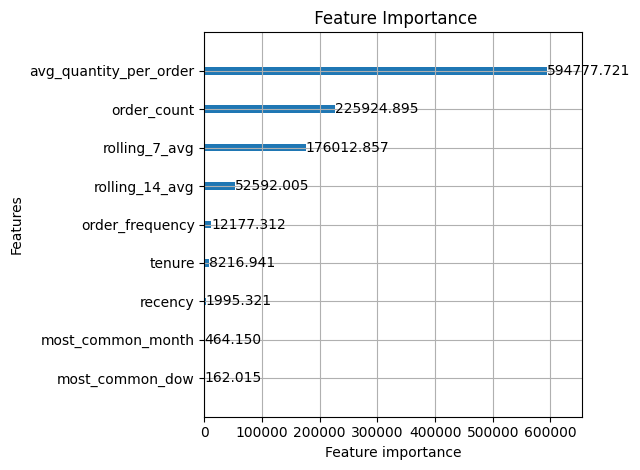

In [179]:
# Feature importance
lgb.plot_importance(reg, max_num_features=10, importance_type='gain')
plt.title(" Feature Importance")
plt.tight_layout()
plt.show()

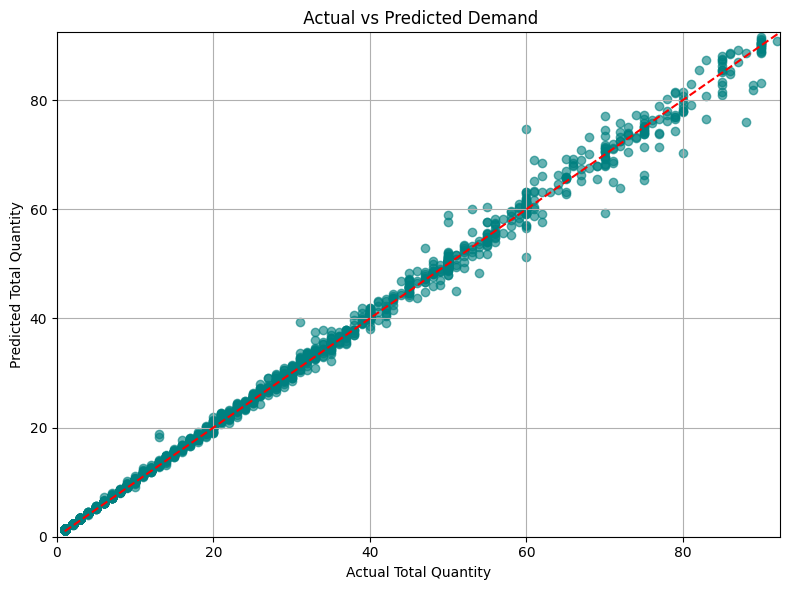

In [180]:
# Actual vs Predicted plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_corrected, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Total Quantity")
plt.ylabel("Predicted Total Quantity")
plt.title(" Actual vs Predicted Demand")
plt.xlim(0, np.percentile(y_test, 95))
plt.ylim(0, np.percentile(y_test, 95))
plt.grid(True)
plt.tight_layout()
plt.show()

In [181]:

#Export Actual vs Predicted with item_name
X_test_with_index = X_test.copy()
X_test_with_index["actual_quantity"] = y_test
X_test_with_index["predicted_quantity"] = y_pred_corrected
X_test_with_index["customer_id"] = sku_demand.loc[y_test.index, "customer_id"].values
X_test_with_index["item_name"] = sku_demand.loc[y_test.index, "item_name"].values

actual_vs_predicted_df = X_test_with_index[["customer_id", "item_name", "actual_quantity", "predicted_quantity"]]
actual_vs_predicted_df.to_excel("actual_vs_predicted_FINAL.xlsx", index=False)

In [182]:

#Export Actual vs Predicted with item_name
avsp = features.copy()
avsp["actual_quantity"] = target
avsp["predicted_quantity"] = np.expm1(reg.predict(features)) + (target - np.expm1(reg.predict(features))).mean()
avsp["customer_id"] = sku_demand.loc[target.index, "customer_id"].values
avsp["item_name"] = sku_demand.loc[target.index, "item_name"].values

avsp_overall = avsp[["customer_id", "item_name", "actual_quantity", "predicted_quantity"]]
avsp_overall
# avsp_overall.to_excel("actual_vs_predicted_FINAL.xlsx", index=False)

,customer_id,item_name,actual_quantity,predicted_quantity
0,1,Adani Patla Besan,1,1.673234
1,1,Arhar Dal,1,1.672055
2,1,Arrarot,9,9.806851
3,1,Ashok Chaat Masala Pkt(100gm),20,20.724115
4,1,Ashok Kitchen King Masala Pkt(100gm),10,10.590416
...,...,...,...,...
32456,9352,Deepak Aata,1,1.672502
32457,9352,Deepak Maida,1,1.672502
32458,9358,Tata Salt Pkt(1Kg),20,20.641585
32459,9367,Prakash Maida,3,3.674897


In [183]:
#Forecast for next 14 days
future_days = pd.date_range(start=latest_date + timedelta(days=1), periods=14)
num_days = len(future_days)

# Repeat rows for each future day
repeated_df = pd.concat([sku_demand]*num_days, ignore_index=True)
repeated_df["date"] = np.tile(future_days, len(sku_demand))
repeated_df

,customer_id,item_name,total_quantity,first_order_date,last_order_date,order_count,most_common_dow,most_common_month,rolling_7_avg,rolling_14_avg,recency,tenure,avg_quantity_per_order,order_frequency,rolling_7_std,date
0,1,Adani Patla Besan,1,2025-02-06,2025-02-06,1,3,2,NaN,NaN,63,63,1.0,0.015873,1.978709,2025-04-11
1,1,Arhar Dal,1,2025-02-10,2025-02-10,1,0,2,NaN,NaN,59,59,1.0,0.016949,1.978709,2025-04-12
2,1,Arrarot,9,2024-10-06,2025-04-01,9,6,1,1.0,1.0,9,186,1.0,0.048387,1.978709,2025-04-13
3,1,Ashok Chaat Masala Pkt(100gm),20,2024-11-22,2024-11-22,1,4,11,NaN,NaN,139,139,20.0,0.007194,1.978709,2025-04-14
4,1,Ashok Kitchen King Masala Pkt(100gm),10,2024-12-04,2024-12-04,1,2,12,NaN,NaN,127,127,10.0,0.007874,1.978709,2025-04-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454449,9352,Deepak Aata,1,2025-04-10,2025-04-10,1,3,4,NaN,NaN,0,0,1.0,inf,1.978709,2025-04-20
454450,9352,Deepak Maida,1,2025-04-10,2025-04-10,1,3,4,NaN,NaN,0,0,1.0,inf,1.978709,2025-04-21
454451,9358,Tata Salt Pkt(1Kg),20,2025-04-10,2025-04-10,1,3,4,NaN,NaN,0,0,20.0,inf,1.978709,2025-04-22
454452,9367,Prakash Maida,3,2025-04-10,2025-04-10,1,3,4,NaN,NaN,0,0,3.0,inf,1.978709,2025-04-23


In [184]:
# Update time-dependent features
repeated_df["most_common_dow"] = repeated_df["date"].dt.dayofweek
repeated_df["most_common_month"] = repeated_df["date"].dt.month

# Prepare future features
X_future = repeated_df[features.columns]
future_preds_log = reg.predict(X_future)
future_preds = np.expm1(future_preds_log) + bias
repeated_df["predicted_quantity"] = future_preds

In [185]:
# Final forecast per customer-SKU
forecast_df = repeated_df[["date", "customer_id", "item_name", "predicted_quantity"]]
print("\nForecasted Demand per Customer per SKU for Next 14 Days:")
print(forecast_df.head())

#Inventory requirement per SKU per day
inventory_forecast = (
    forecast_df.groupby(["date", "item_name"])["predicted_quantity"]
    .sum()
    .reset_index()
    .rename(columns={"predicted_quantity": "total_forecast_quantity"})
)
print("\nTotal Inventory Requirement (All Customers Combined) per SKU per Day:")
print(inventory_forecast.head())


Forecasted Demand per Customer per SKU for Next 14 Days:
        date  customer_id                             item_name  \
0 2025-04-11            1                     Adani Patla Besan   
1 2025-04-12            1                             Arhar Dal   
2 2025-04-13            1                               Arrarot   
3 2025-04-14            1         Ashok Chaat Masala Pkt(100gm)   
4 2025-04-15            1  Ashok Kitchen King Masala Pkt(100gm)   

   predicted_quantity  
0            1.324854  
1            1.317477  
2            9.354294  
3           20.635682  
4           10.212640  

Total Inventory Requirement (All Customers Combined) per SKU per Day:
        date                       item_name  total_forecast_quantity
0 2025-04-11                     7 Star Rice               885.525480
1 2025-04-11                    A1 Arhar Dal                59.192325
2 2025-04-11              AJMAL BASMATI RICE               404.409269
3 2025-04-11    ASHOK BIRYANI MASALA (50 GM)

In [186]:
forecast_df

,date,customer_id,item_name,predicted_quantity
0,2025-04-11,1,Adani Patla Besan,1.324854
1,2025-04-12,1,Arhar Dal,1.317477
2,2025-04-13,1,Arrarot,9.354294
3,2025-04-14,1,Ashok Chaat Masala Pkt(100gm),20.635682
4,2025-04-15,1,Ashok Kitchen King Masala Pkt(100gm),10.212640
...,...,...,...,...
454449,2025-04-20,9352,Deepak Aata,1.305183
454450,2025-04-21,9352,Deepak Maida,1.320855
454451,2025-04-22,9358,Tata Salt Pkt(1Kg),20.163697
454452,2025-04-23,9367,Prakash Maida,3.325356


In [187]:
inventory_forecast

,date,item_name,total_forecast_quantity
0,2025-04-11,7 Star Rice,885.525480
1,2025-04-11,A1 Arhar Dal,59.192325
2,2025-04-11,AJMAL BASMATI RICE,404.409269
3,2025-04-11,ASHOK BIRYANI MASALA (50 GM),24.666058
4,2025-04-11,ASHOK KALI MIRCH POWDER (100g),24.566701
...,...,...,...
8493,2025-04-24,Yellow Chilli Powder,16.823293
8494,2025-04-24,chhuara,1.309143
8495,2025-04-24,kali Khatai Pkt(250gm),18.738936
8496,2025-04-24,mayonise,5.307011


In [188]:
import pandas as pd
import numpy as np

# Reverse transformation of actual and predicted if log1p + bias was used
y_test_actual = np.expm1(y_test) + bias  # Adjust if you used a bias during modeling
y_predicted = np.expm1(y_pred) + bias

# Create a DataFrame for evaluation
eval_df = pd.DataFrame({
    "total_actual_quantity": y_test_actual,
    "total_forecast_quantity": y_predicted
})

# Inventory risk detection using 98%-102% logic
eval_df["risk_flag"] = "OK"  # Default value

eval_df["risk_flag"] = np.where(
    eval_df["total_forecast_quantity"] < 0.98 * eval_df["total_actual_quantity"],
    "Stockout Risk",
    eval_df["risk_flag"]
)

eval_df["risk_flag"] = np.where(
    eval_df["total_forecast_quantity"] > 1.02 * eval_df["total_actual_quantity"],
    "Overstock Risk",
    eval_df["risk_flag"]
)

# Sample Output
print("\n Inventory Planning Flags (Sample):")
print(eval_df[["total_actual_quantity", "total_forecast_quantity", "risk_flag"]].head())

# Optional: Save to Excel
eval_df.to_excel("demand_risk_analysis_test_data.xlsx", index=False)



 Inventory Planning Flags (Sample):
       total_actual_quantity  total_forecast_quantity       risk_flag
22212           6.713861e+00             7.090931e+00  Overstock Risk
5001            4.556061e+71             3.948758e+69   Stockout Risk
25368           7.200490e+10             6.151506e+10   Stockout Risk
17314           2.043087e+00             2.049611e+00              OK
4783            4.424127e+05             8.062733e+05  Overstock Risk


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-188-3a248dd03a1f>:6: RuntimeWarning: overflow encountered in expm1
  y_predicted = np.expm1(y_pred) + bias


In [189]:
# Export to a new Excel file
eval_df.to_excel("inventory_risk_test_set.xlsx", index=False)

print("Risk flags saved to 'inventory_risk_test_set.xlsx'")

Risk flags saved to 'inventory_risk_test_set.xlsx'


In [190]:
import pandas as pd
import numpy as np

# Assuming y_test and y_pred are your model's predictions and actuals, respectively
# And X_test is the feature set for the test data

# Inverse transform log values (if applicable)
y_test_actual = np.expm1(y_test) + bias
y_predicted = np.expm1(y_pred) + bias

# Merge predictions with IDs from X_test
test_results = X_test.copy()

# Ensure 'item_id' and 'warehouse_id' are in X_test, otherwise adjust your feature engineering steps
if "item_id" not in X_test.columns or "warehouse_id" not in X_test.columns:
    print("item_id' or 'warehouse_id' not found in the test dataset!")
else:
    test_results["total_actual_quantity"] = y_test_actual
    test_results["total_forecast_quantity"] = y_predicted

    # Group by item and warehouse to get cumulative actual & forecast quantities
    summary_df = test_results.groupby(["item_id", "warehouse_id"], as_index=False).agg({
        "total_actual_quantity": "sum",
        "total_forecast_quantity": "sum"
    })

    # Apply risk flag logic
    summary_df["risk_flag"] = "OK"

    summary_df["risk_flag"] = np.where(
        summary_df["total_forecast_quantity"] < 0.98 * summary_df["total_actual_quantity"],
        "Stockout Risk",
        summary_df["risk_flag"]
    )

    summary_df["risk_flag"] = np.where(
        summary_df["total_forecast_quantity"] > 1.02 * summary_df["total_actual_quantity"],
        "Overstock Risk",
        summary_df["risk_flag"]
    )

    # Save to Excel
    summary_df.to_excel("warehouse_item_inventory_risk_analysis.xlsx", index=False)

    print("Inventory risk analysis saved to 'warehouse_item_inventory_risk_analysis.xlsx'")


item_id' or 'warehouse_id' not found in the test dataset!


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-190-65732fd66803>:9: RuntimeWarning: overflow encountered in expm1
  y_predicted = np.expm1(y_pred) + bias


In [191]:
X_test

,recency,tenure,order_count,most_common_dow,most_common_month,rolling_7_avg,rolling_14_avg,avg_quantity_per_order,order_frequency,rolling_7_std
22212,5,5,1,5,4,1.000000,1.000000,2.000000,0.200000,1.978709
5001,95,156,4,3,11,30.833333,30.833333,41.250000,0.025641,1.978709
25368,143,143,1,0,11,NaN,NaN,25.000000,0.006993,1.978709
17314,43,43,1,2,2,NaN,NaN,1.000000,0.023256,1.978709
4783,6,191,4,5,10,2.062500,2.062500,3.250000,0.020942,1.978709
...,...,...,...,...,...,...,...,...,...,...
2359,64,129,11,3,12,4.118831,3.727581,5.636364,0.085271,1.978709
1599,175,189,2,3,10,1.000000,1.000000,1.000000,0.010582,1.978709
15680,42,42,1,3,2,NaN,NaN,4.000000,0.023810,1.978709
19182,76,189,14,4,1,3.232234,3.274749,3.214286,0.074074,1.978709


In [192]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor

# ... (your previous code for loading and preprocessing data) ...

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Log-transform target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Handle missing values and infinite values in X_train and X_test
X_train = X_train.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
X_test = X_test.replace([np.inf, -np.inf], np.nan)    # Replace infinite values with NaN
X_train = X_train.fillna(X_train.mean())  # Fill NaN values with the mean of each column
X_test = X_test.fillna(X_test.mean())    # Fill NaN values with the mean of each column


# Train model
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train_log)

xgb.fit(X_train, y_train_log)

# Predictions
y_train_pred_log = xgb.predict(X_train)
y_test_pred_log = xgb.predict(X_test)

# Inverse-transform predictions
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

# Bias correction
bias = (y_test - y_test_pred).mean()
y_train_pred_corrected = y_train_pred + bias
y_test_pred_corrected = y_test_pred + bias

# Evaluation Function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    accuracy_within_10 = np.mean(np.abs((y_true - y_pred) / y_true) <= 0.10) * 100
    return mae, rmse, r2, mape, accuracy_within_10

# Metrics
train_mae, train_rmse, train_r2, _, _ = evaluate_model(y_train, y_train_pred_corrected)
test_mae, test_rmse, test_r2, test_mape, test_accuracy = evaluate_model(y_test, y_test_pred_corrected)

# Print Results
print(" xgb Evaluation:")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAPE: {test_mape:.2f} %")
print(f"Test Accuracy (±10%): {test_accuracy:.2f} %")


 xgb Evaluation:
Train MAE: 1.50
Train RMSE: 34.64
Train R²: 0.9206
Test MAE: 2.00
Test RMSE: 27.04
Test R²: 0.8563
Test MAPE: 18.94 %
Test Accuracy (±10%): 42.94 %
